In [1]:
from graph_tool.all import *

In [55]:
from collections import namedtuple
from numpy import array

from graph_tool.all import *

NVISITS = 5
RMAX = 10. # limit field of view for testing

# generate a direted graph 
g = Graph(directed=True)

#v = g.add_vertex() # vertex 0 will be the source vertex
#v = g.add_vertex() # vertex 1 will be the sink vertex

# load all cobra positions in the PFI focal plane
Cobra = namedtuple('Cobra', ['id','x', 'y', 'vertex_index'], verbose=False)
CobraVisit = namedtuple('CobraVisit', ['cid','visit','vertex_index'], verbose=False)

ffiberpos = "data/fiberpos.txt"
cobras = {}
cobraVisits = {}
with open(ffiberpos) as f:
    ll = f.readlines()
    for l in ll[1:]:
        tt = l.replace(":","").split()
        x,y = float(tt[1]),float(tt[2])
        if x**2 + y**2 > RMAX**2:
            continue
        v1 = g.add_vertex()
        cid = str(tt[0])
        c = Cobra(id=cid,x=x,y=y,vertex_index=g.vertex_index[v1])
        cobras[tt[0]] = c
        # replicate node as many times as there are visits
        for visit in range(NVISITS):
            v2 = g.add_vertex()
            cv = CobraVisit(cid=cid,visit=visit,vertex_index=g.vertex_index[v2])
            cobraVisits[(cid,visit)] = cv 
            e = g.add_edge(v2, v1)

In [56]:
# load all target positions in the PFI focal plane
Target = namedtuple('Target', ['id','x', 'y', 'vertex_index'], verbose=False)
TargetVisit = namedtuple('TargetVisit', ['tid','visit','vertex_index'], verbose=False)

ftarget = "data/target.txt"
targets = {}
targetVisits = {}
with open(ftarget) as f:
    ll = f.readlines()
    for i,l in enumerate(ll[1:]):
        tt = l.replace(":","").split()
        x,y = float(tt[1]),float(tt[2])
        if x**2 + y**2 > RMAX**2:
            continue
        v2 = g.add_vertex()
        tid = str(tt[0])
        t = Target(id=tid,x=x,y=y,vertex_index=g.vertex_index[v2])
        targets[tid] = t
        # replicate node as many times as there are visits
        for visit in range(NVISITS):
            v1 = g.add_vertex()
            tv = TargetVisit(tid=tid,visit=visit,vertex_index=g.vertex_index[v1])
            targetVisits[(tid,visit)] = tv
            e = g.add_edge(v2, v1)

In [57]:
# load information on which cobra can access which target
# and add corresponding edges
fvisibility = "data/visibility.txt"
with open(fvisibility) as f:
    ll = f.readlines()
    # loop over all lines, which will loop over all targets
    for i,l in enumerate(ll[1:]):
        tt = l.replace(":","").split()
        tid = str(tt[0])
        # these are all the cobras that the target can be reached by
        cobra_ids = [str(t) for t in tt[1:]]
        # bail out if we didn't include use this target
        if not targets.has_key(tid):
            continue
        # Now we need to add edges between cobra visits and target visits.
        # So for each visit, link all cobras that can reach
        # a specific target to that target.
        for visit in range(NVISITS):
            tv = targetVisits[(tid,visit)]
            for cid in cobra_ids:
                # bail out if we didn't include use this cobra
                if not cobras.has_key(cid):
                    continue
                cv = cobraVisits[(cid,visit)]
                e = g.add_edge(g.vertex( tv.vertex_index ),
                               g.vertex( cv.vertex_index ))

In [58]:
# add target super node
# later ther should be one supernode for each priority class
targetSuperNode = g.add_vertex()
for tid,t in targets.iteritems():
    v2id = targets[tid].vertex_index
    v2 = g.vertex(v2id)
    e = g.add_edge(targetSuperNode, v2)

In [59]:
# add arcs from source to cobra nodes
# and from target nodes to sink node
#v1 = g.vertex(0)
#for cid,c in cobras.iteritems():
#    v2id = cobras[cid].vertex_index
#    v2 = g.vertex(v2id)
#    e = g.add_edge(v1, v2)
    
#v2 = g.vertex(1)
#for tid,t in targets.iteritems():
#    v1id = targets[tid].vertex_index
#    v1 = g.vertex(v1id)
#    e = g.add_edge(v1, v2)

In [60]:
#import matplotlib.pyplot as plt
#%matplotlib inline

In [61]:
#f = plt.figure(figsize=[10,10])
#plt.plot([cobras[c].x for c in cobras],[cobras[c].y for c in cobras],'.')

#plt.plot([targets[t].x for t in targets],[targets[t].y for t in targets],'rx')

#plt.axis('equal')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.xlim([-50,50])
#plt.ylim([-50,50])

In [62]:
#pos = sfdp_layout(g)
pos = g.new_vertex_property("vector<double>")
vt = g.new_vertex_property("double")
vn = g.new_vertex_property("string")

en = g.new_edge_property("string")

In [63]:
#vt[g.vertex(0)] = 0. # source node color
#vt[g.vertex(1)] = 1. # sink node color
#pos[g.vertex(0)] = -RMAX,0. # source node positions
#pos[g.vertex(1)] = +RMAX,0. # sink node positions

In [64]:
# set node positions
ncobras = len(cobras)
ntargets = len(targets)
ncobraVisits = len(cobraVisits)
ntargetVisits = len(targetVisits)

In [65]:
YSIZE = 20.

In [66]:
for i,(cid,c) in enumerate(cobras.iteritems()):
    pos[g.vertex(c.vertex_index)] = (20., YSIZE/ncobras * (float(i)+.5) )
    vt[g.vertex(c.vertex_index)] = 1.
    vn[g.vertex(c.vertex_index)] = "C_{}".format(cid)

In [67]:
dy = YSIZE/(NVISITS*len(cobras))
for i,(cid,t) in enumerate( cobras.iteritems() ):
    for visit in range(NVISITS):
        cv = cobraVisits[(cid,visit)]
        pos[g.vertex(cv.vertex_index)] = (15., dy * (i*NVISITS + visit))
        vt[g.vertex(cv.vertex_index)] = 2.
        vn[g.vertex(cv.vertex_index)] = "C_{}^{}".format(cv.cid,cv.visit)

In [68]:
dy = YSIZE/(NVISITS*len(targets))
for i,(tid,t) in enumerate( targets.iteritems() ):
    for visit in range(NVISITS):
        tv = targetVisits[(tid,visit)]
        
        pos[g.vertex(tv.vertex_index)] = (10., dy * (i*NVISITS + visit))
        vt[g.vertex(tv.vertex_index)] = 3.
        vn[g.vertex(tv.vertex_index)] = "T_{}^{}".format(tv.tid,tv.visit)

In [69]:
for i,(tid,t) in enumerate(targets.iteritems()):
    pos[g.vertex(t.vertex_index)] = (5., YSIZE/ntargets * i)
    vt[g.vertex(t.vertex_index)] = 4.
    vn[g.vertex(t.vertex_index)] = "T_{}".format(tid)

In [70]:
pos[targetSuperNode] = (0.,YSIZE/2.)
vt[targetSuperNode] = 0.
vn[targetSuperNode] = "T"

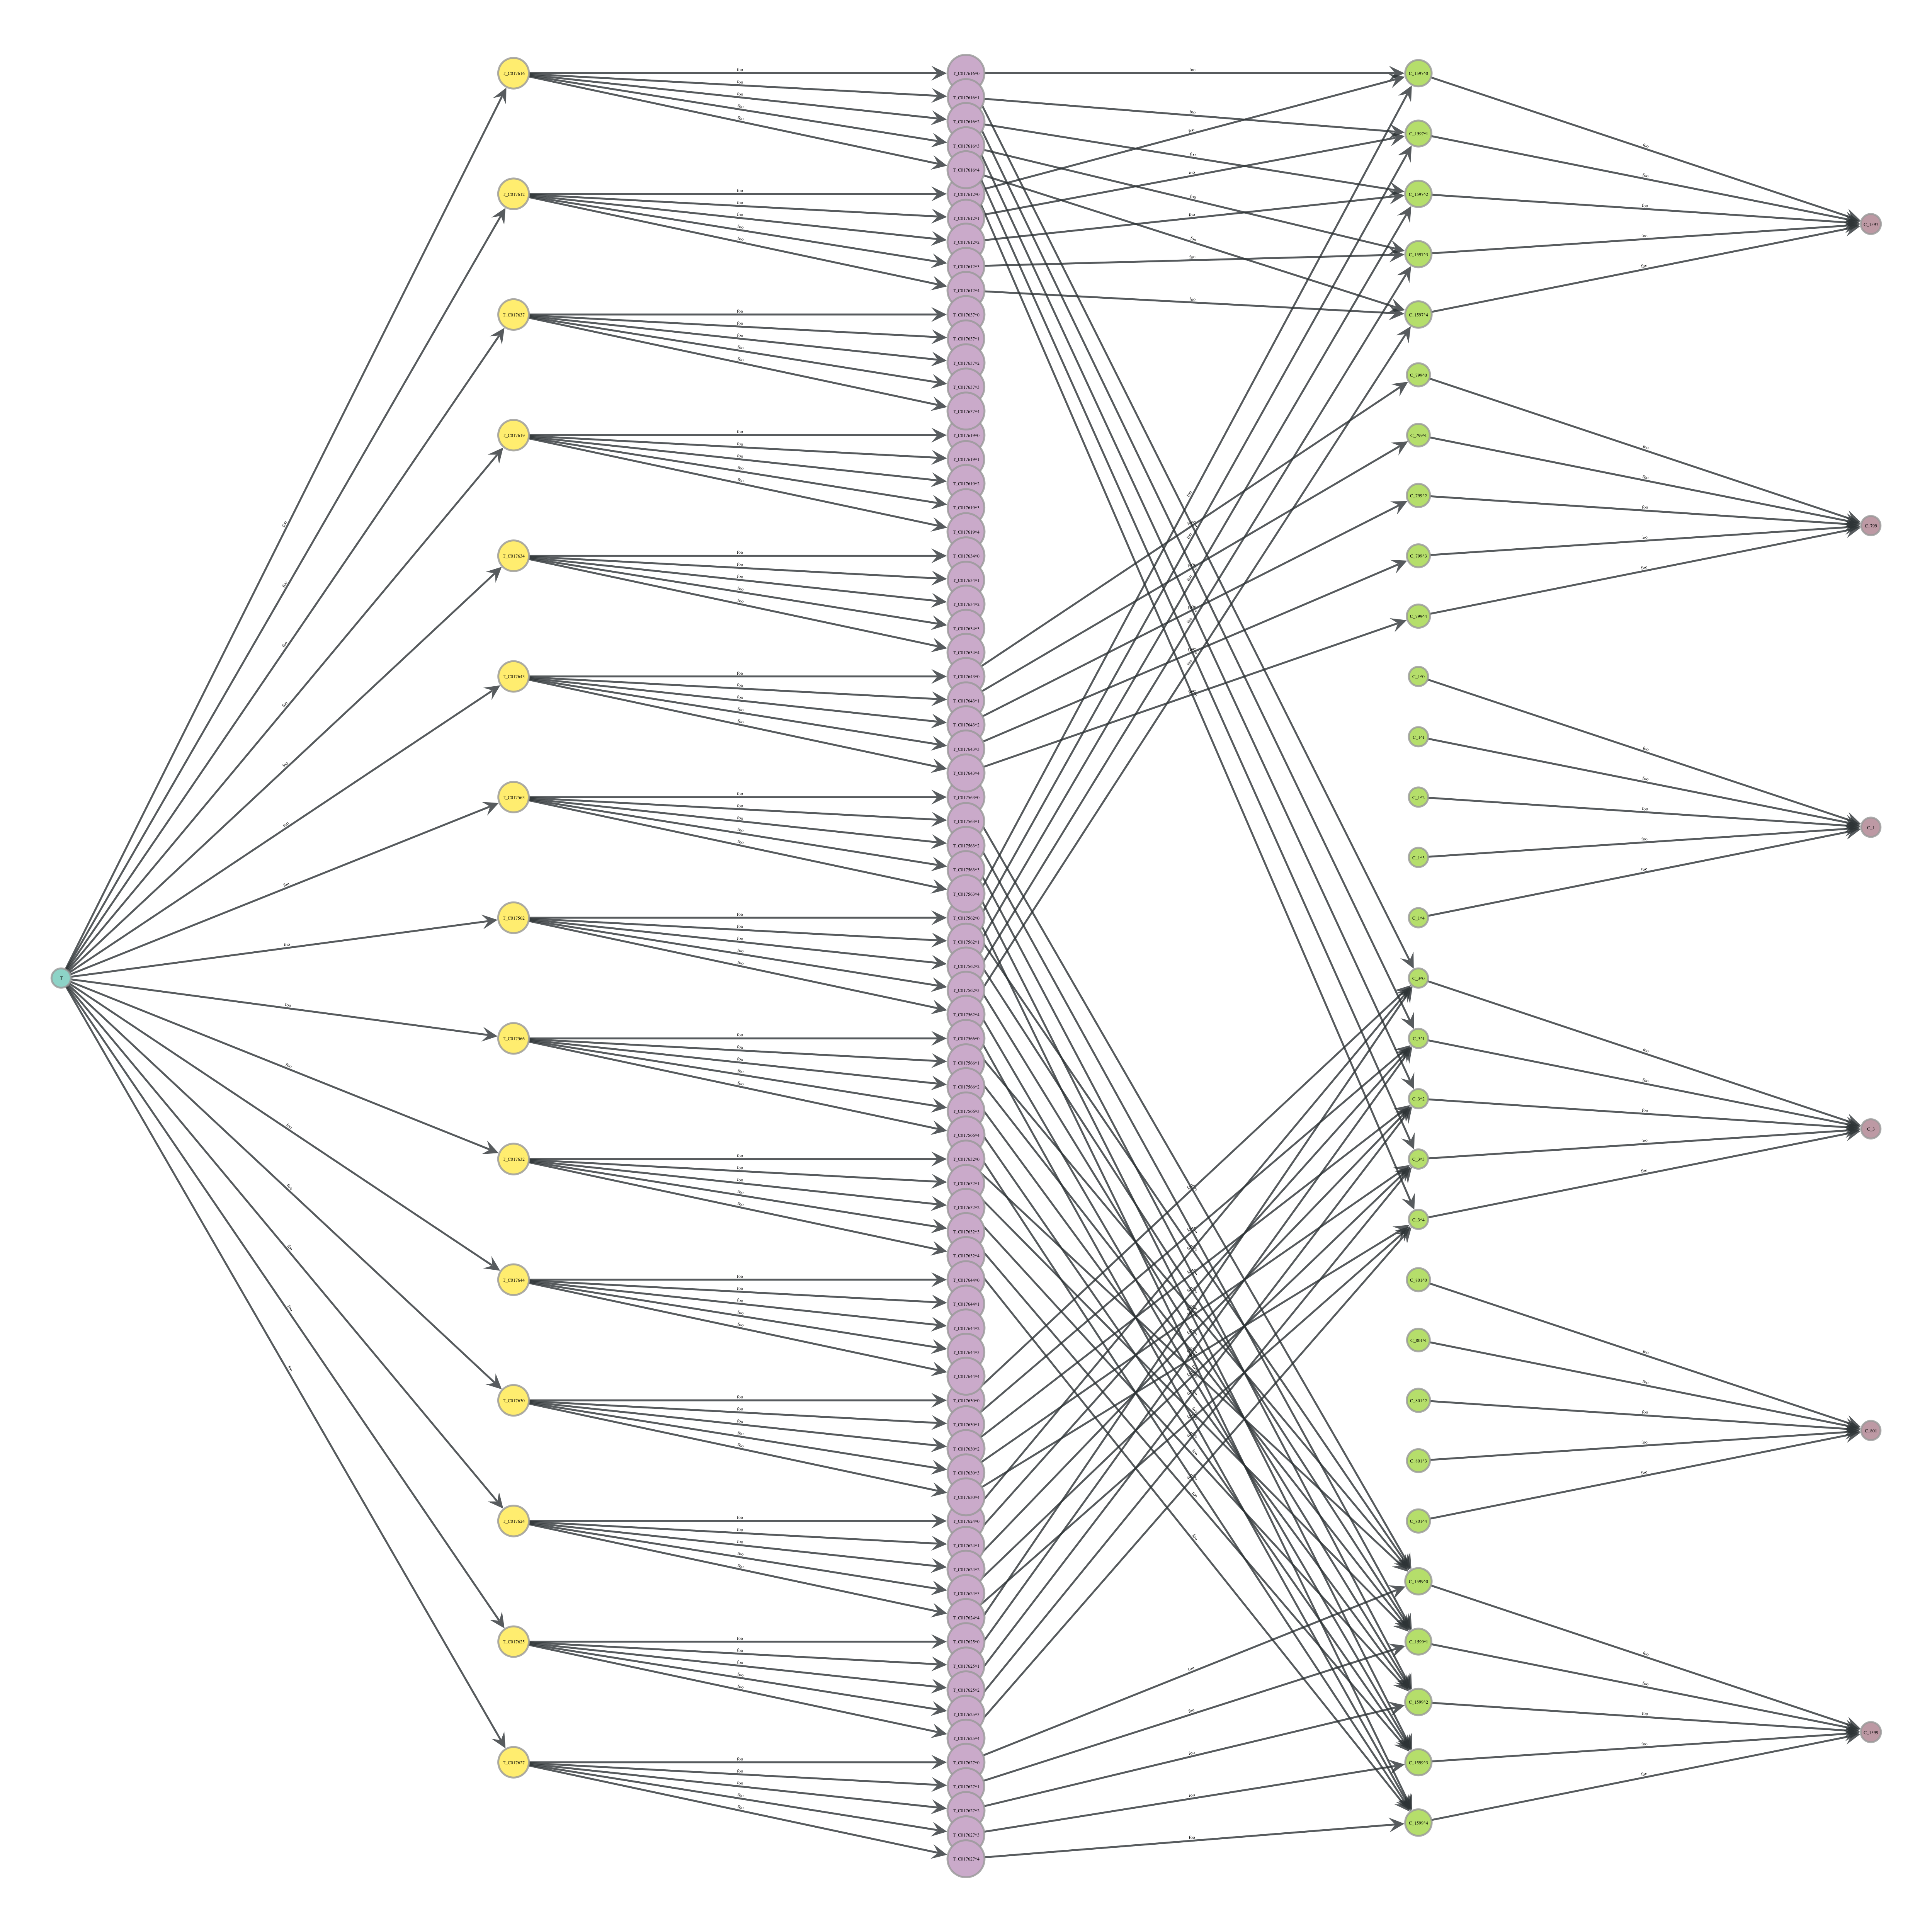

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12579a410, at 0x128ce6850>

In [71]:
#graph_draw(g, pos=pos,vertex_text=g.vertex_index, vertex_fill_color=vt, vertex_font_size=8, vertex_size=25,
#           output_size=(5000, 5000), output="pfi.pdf")

output = None
#output="pfi.pdf"
graph_draw(g, pos=pos,vertex_fill_color=vt, vertex_size=50,vertex_text=vn,edge_text="foo",
           output_size=(5000, 5000), output=output)

In [73]:
print g.num_edges()
print g.num_vertices()

185
127


In [72]:
ntargetVisits

75